In [1]:
# Import necessary libraries
import gempy as gp
import gempy_viewer as gpv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import verde as vd
from gempy_engine.core.data.centered_grid import CenteredGrid
import gemgis as gg
import pyvista as pv

import time, array

from deap import base, creator, tools, algorithms

from CODES.modeling import create_seismic_model,calculate_parameters,calculate_parameters_from_vs
from CODES.dispersion_curves import create_velocity_model_from_profile,estimate_disp_from_velocity_model

from parameters_py.config import (
					MODEL_NAME,FOLDER_OUTPUT
				   )

Setting Backend To: AvailableBackends.numpy


/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


Reading configuration file: ./config_file.cnf


## Ensure reproducible results by fixing seeds for numpy

In [2]:
np.random.seed(42)  # any integer works

# Inputs and outputs

### Directory for saving model and other related stuffs: 

In [3]:
data_path = FOLDER_OUTPUT+MODEL_NAME+'/DATA/'

### Directory for saving figures: 

In [4]:
figures_path = FOLDER_OUTPUT+MODEL_NAME+'/FIGURES/'

----

# Synthetic Surface Wave Dispersion Curves (Observed data)

### Computations of Surface-Wave Phase-Velocity DCs Based on the Reduced Delta Matrix Method

After constructing the model, we computed the synthetic dispersion curves for Rayleigh phase velocities at selected stations,
with an inter-station distance of 10 meters along a 2D profile. The theoretical dispersion curves for each station were generated 
using Dunkin’s approach, which is based on delta matrix theory (Dunkin, 1965). This method was further developed by Herrmann (2013) in CPS330. 

In our codes, we use DISBA, a computationally efficient Python library for the modeling of surface wave dispersion that implements a subset of codes from Computer Programs in Seismology (CPS) in Python compiled just-in-time with numba.

More information see:
- [CPS330](https://www.eas.slu.edu/eqc/ComputerProgramsSeismology/CPS/CPS330/cps330c.pdf)
- [DISBA](https://github.com/keurfonluu/disba)


## Importing the 3D model previously created

In [5]:
density_block = np.load(data_path+'density_block.npy')

In [6]:
density_block.shape

(50, 50, 25)

## Creating a receptors to estimate the surface wave curve in a selected slice:

In [22]:
lst_receptor_index = np.arange(1, density_block.shape[0]-1,5)

In [23]:
lst_receptor_index

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])

In [24]:
station_lst = list(range(1,len(lst_receptor_index)+1))

In [25]:
station_lst

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [32]:
line_row = np.random.randint(low=0,high=density_block.shape[0]-1)
line_row

20

In [33]:
slice_block = density_block[line_row,:,:].T

### Plotting the scheme: Receptors and slice

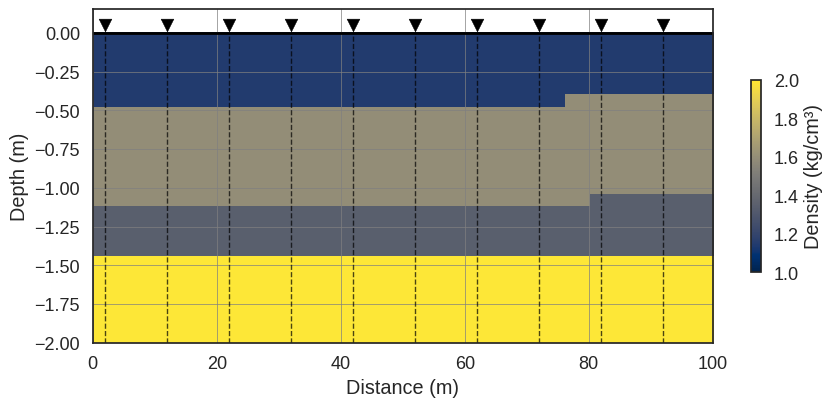

In [34]:
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(slice_block, cmap='cividis',extent=[0, 100, -2.0, 0],vmin=1.0,vmax=2.0,aspect=25,origin='lower')

for ix in lst_receptor_index:
    ax.vlines(x=ix*2,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix*2,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Depth (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Density (kg/cm³)')
fig.savefig(figures_path+'model_slice_and_receptors.png')

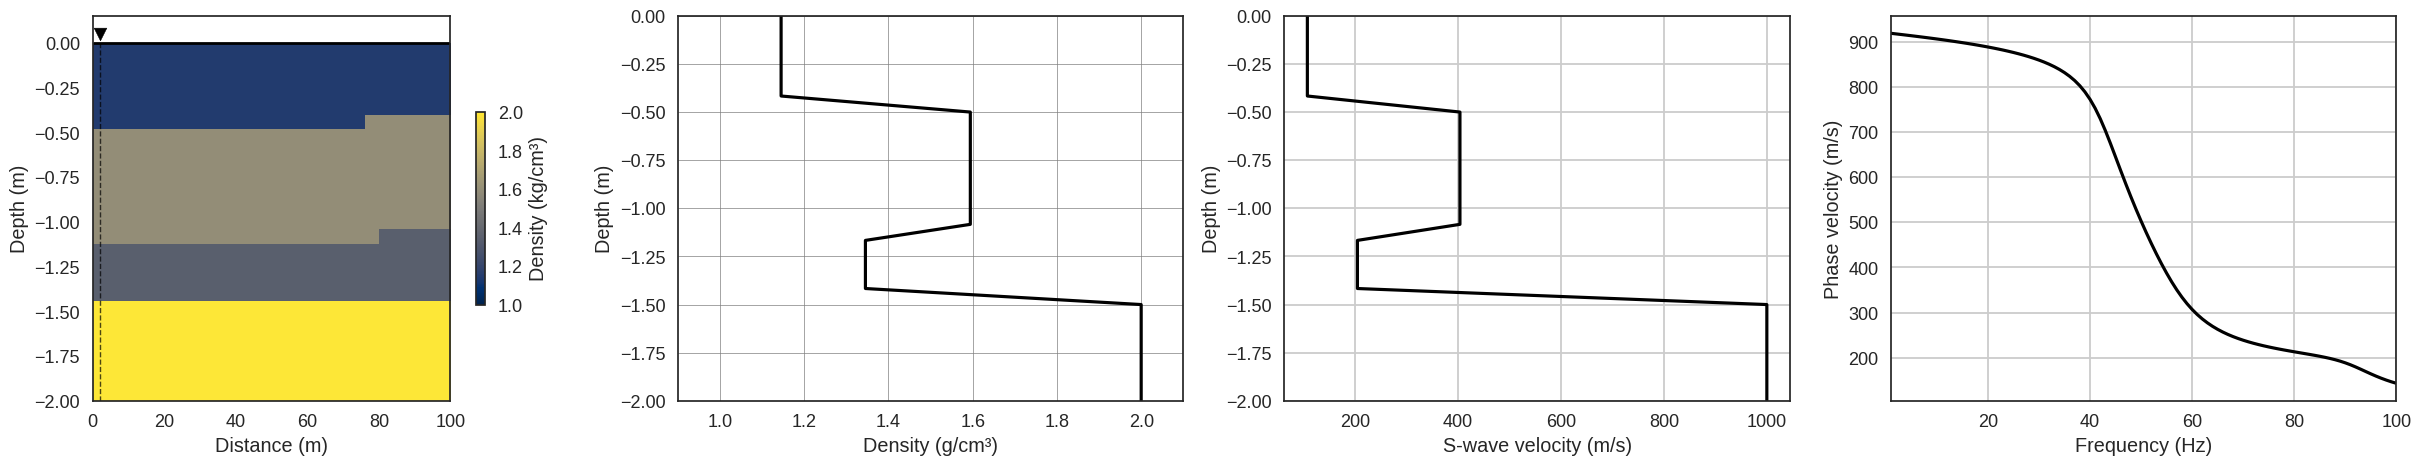

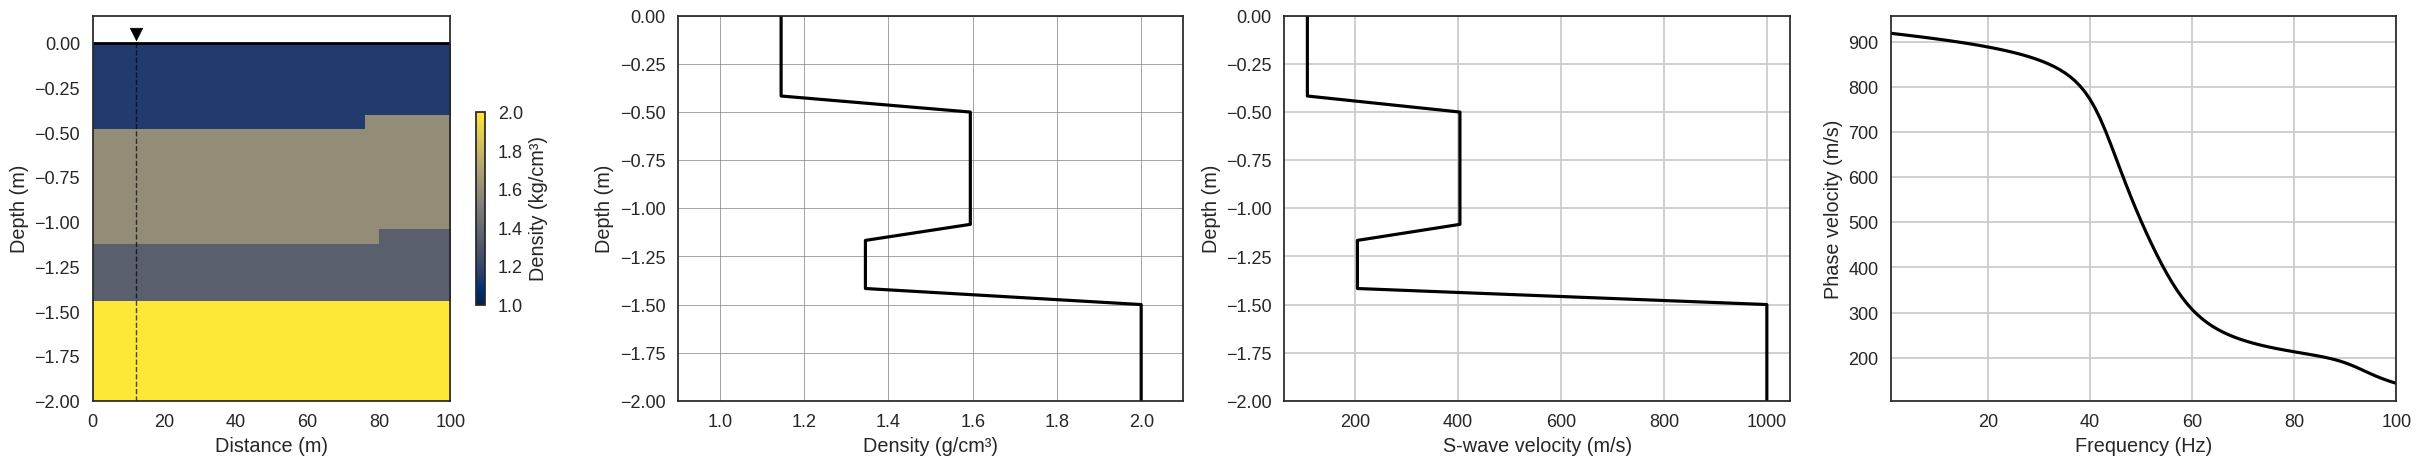

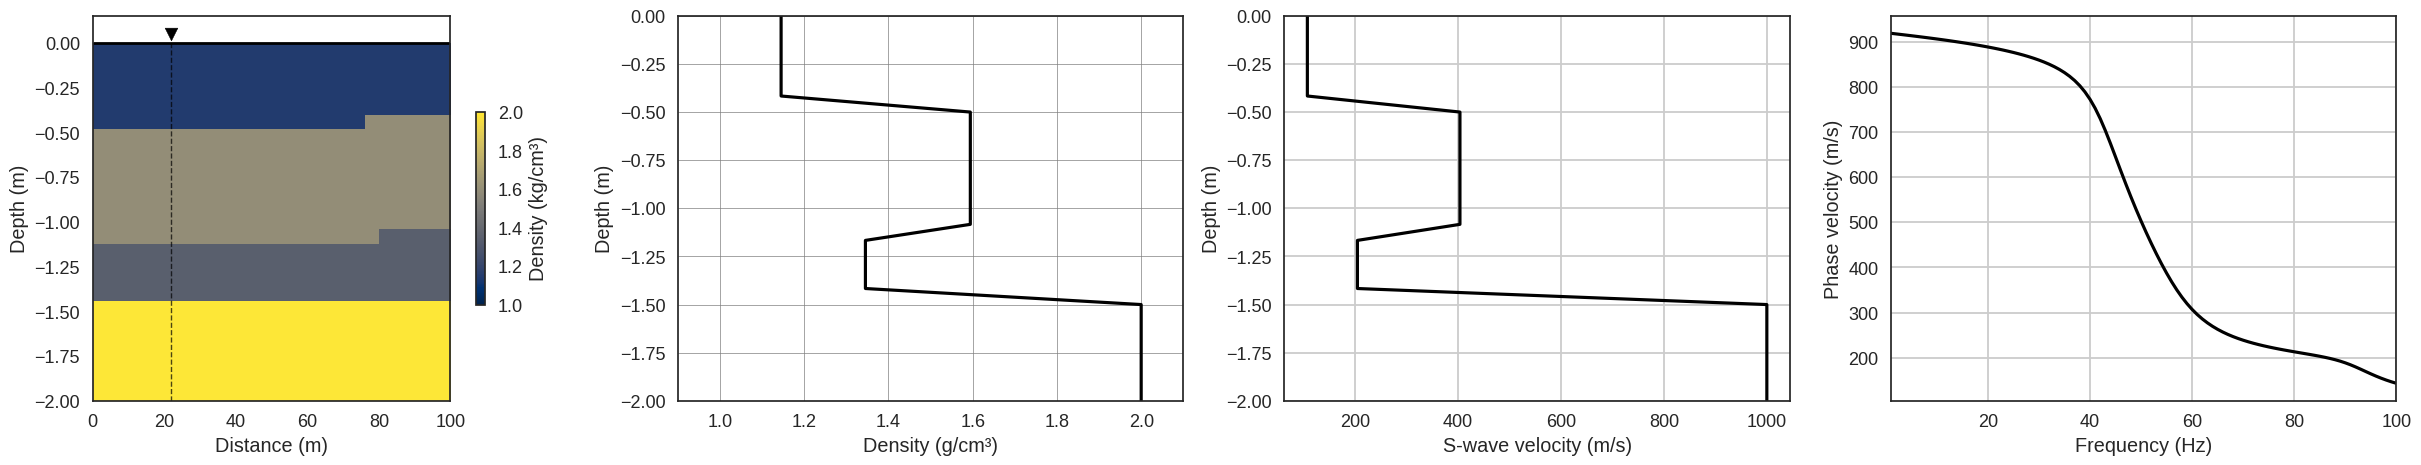

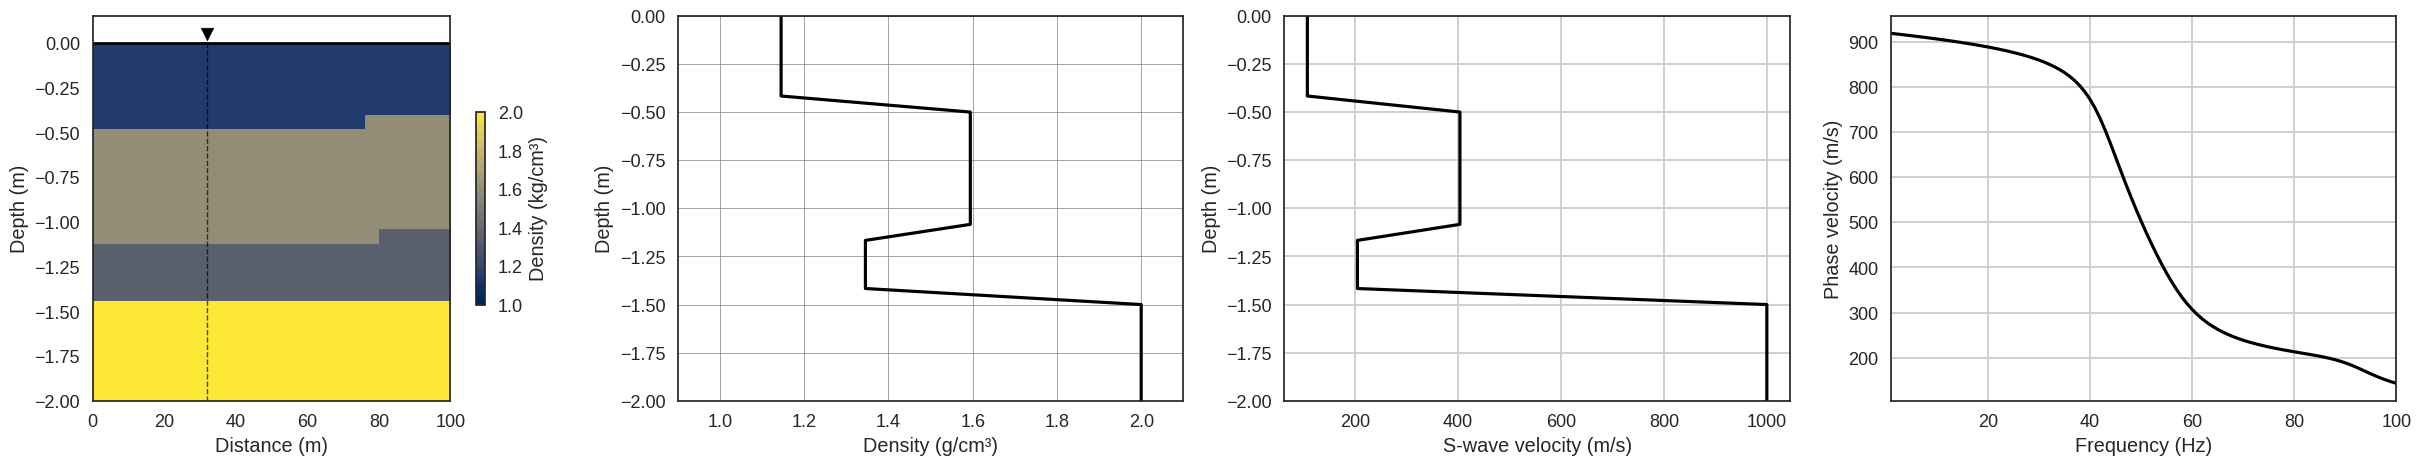

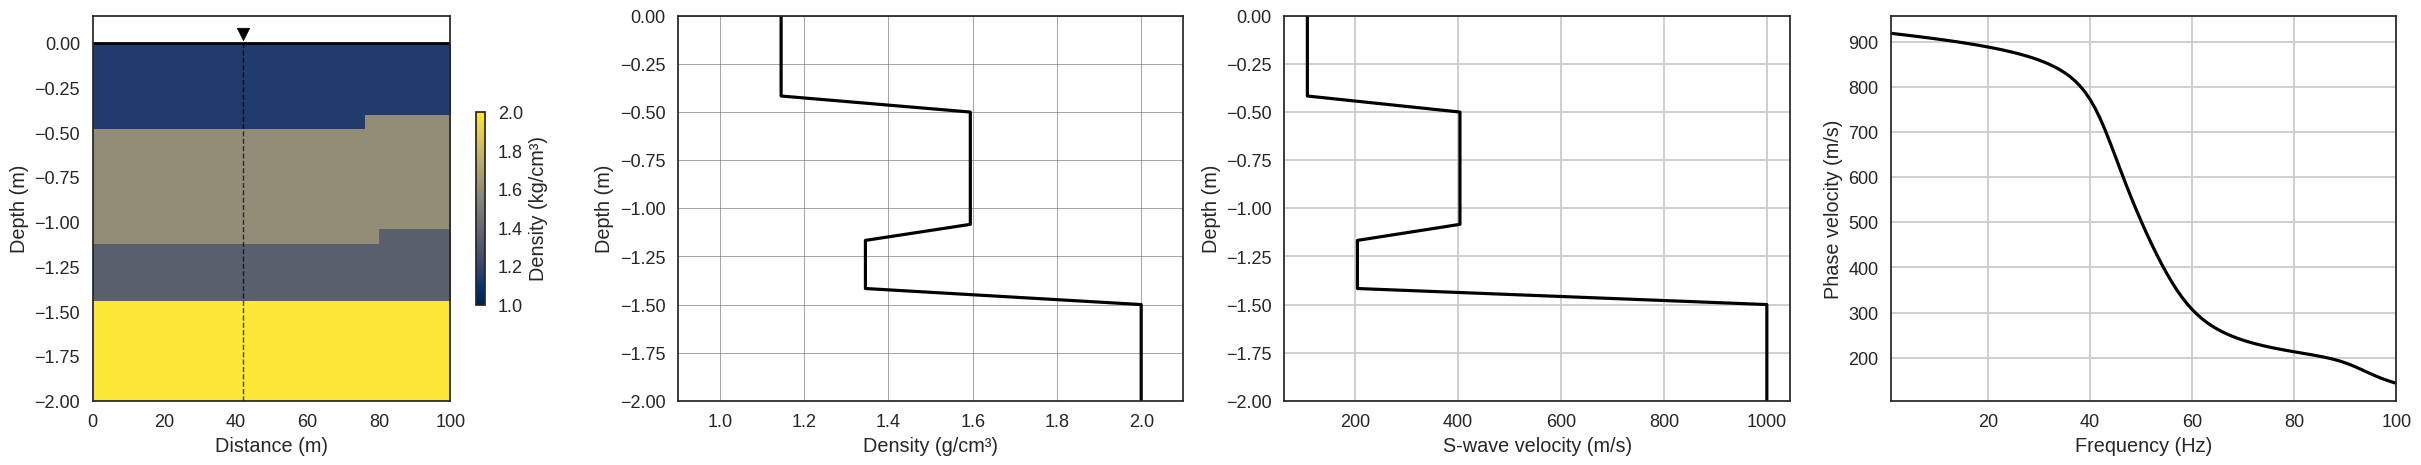

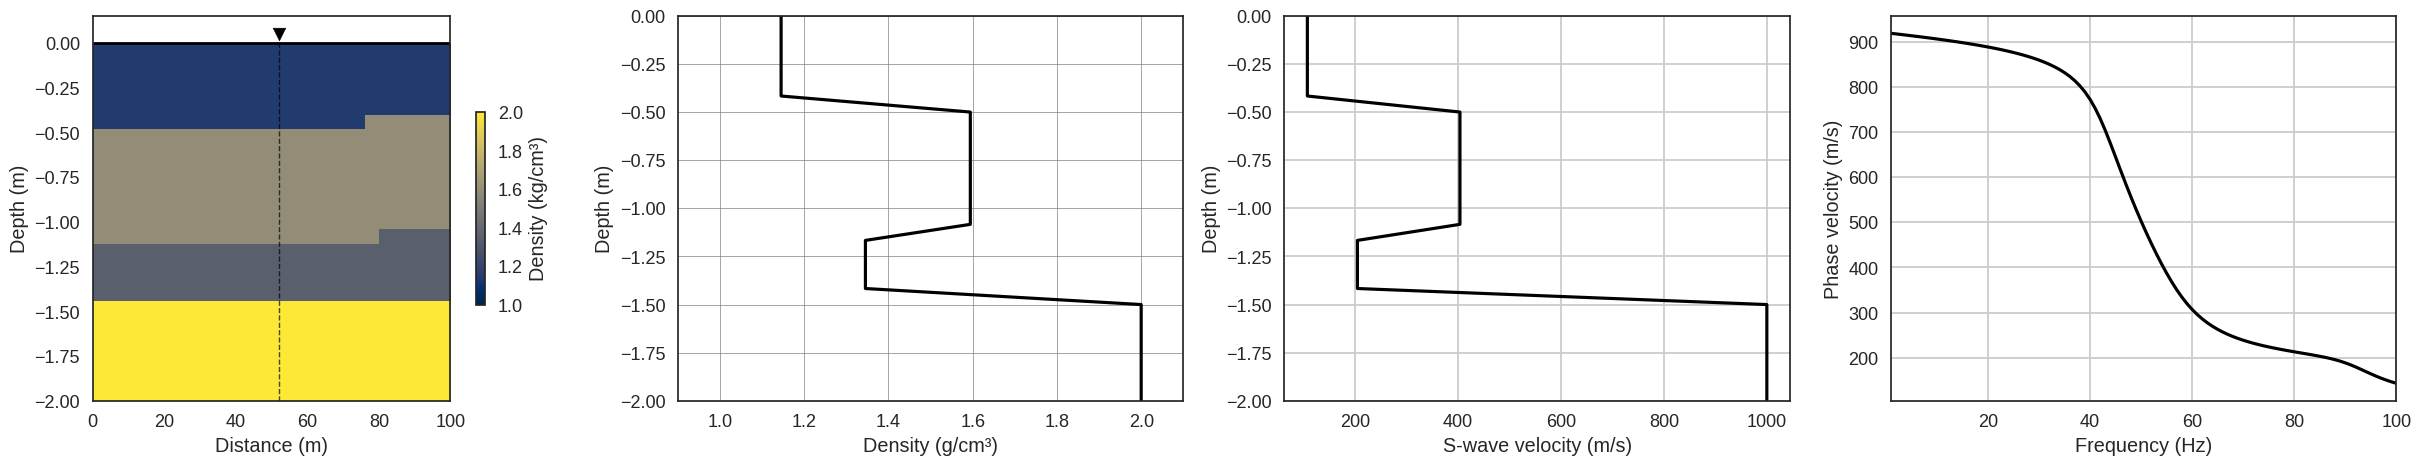

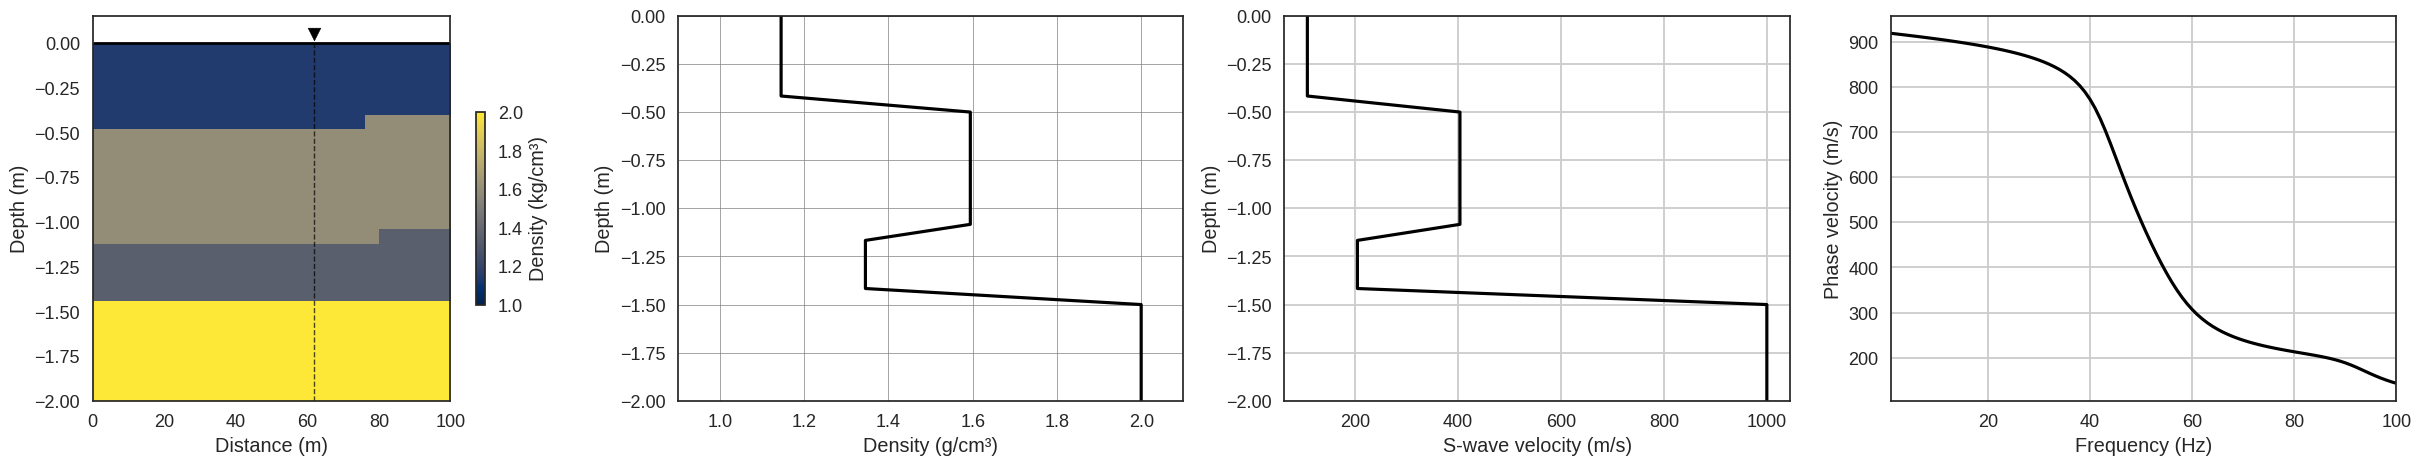

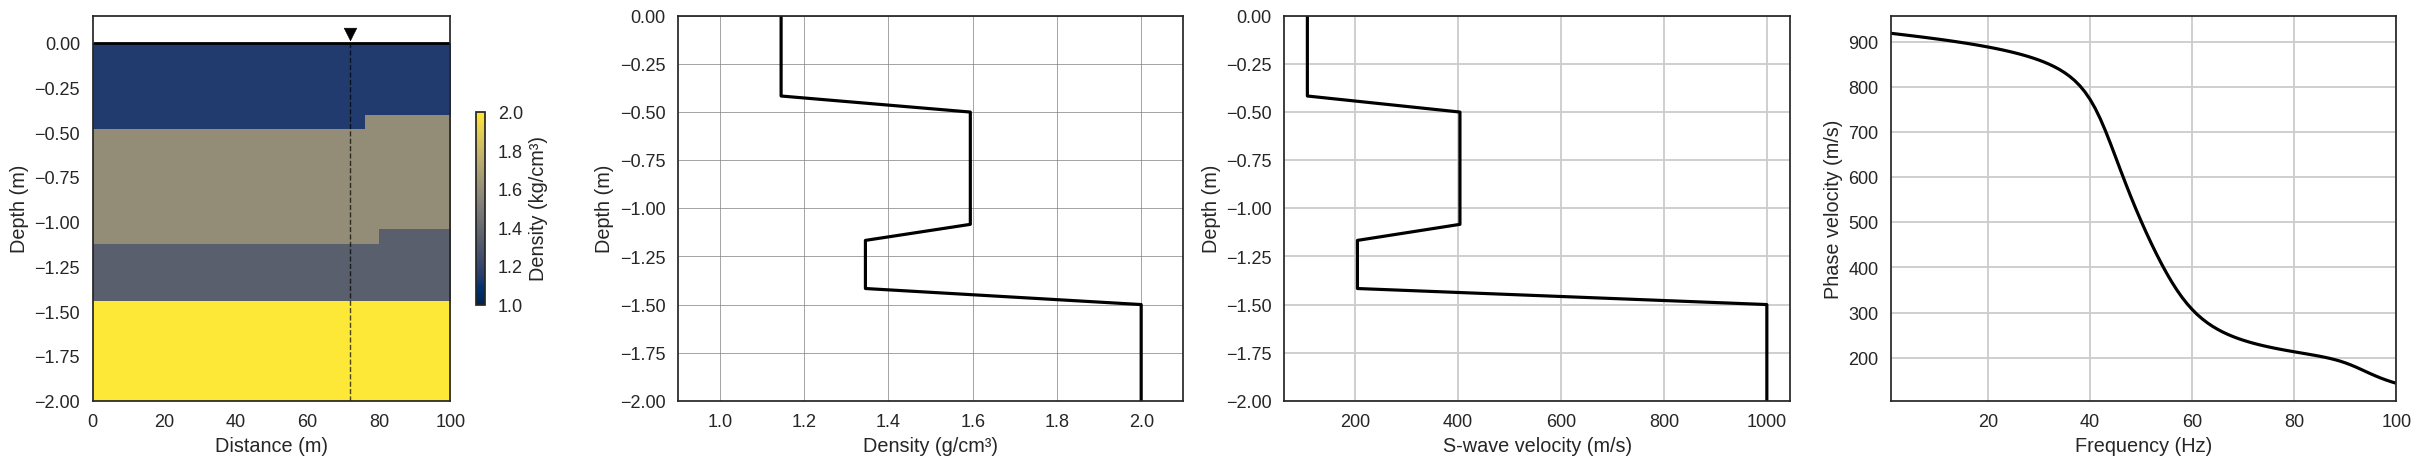

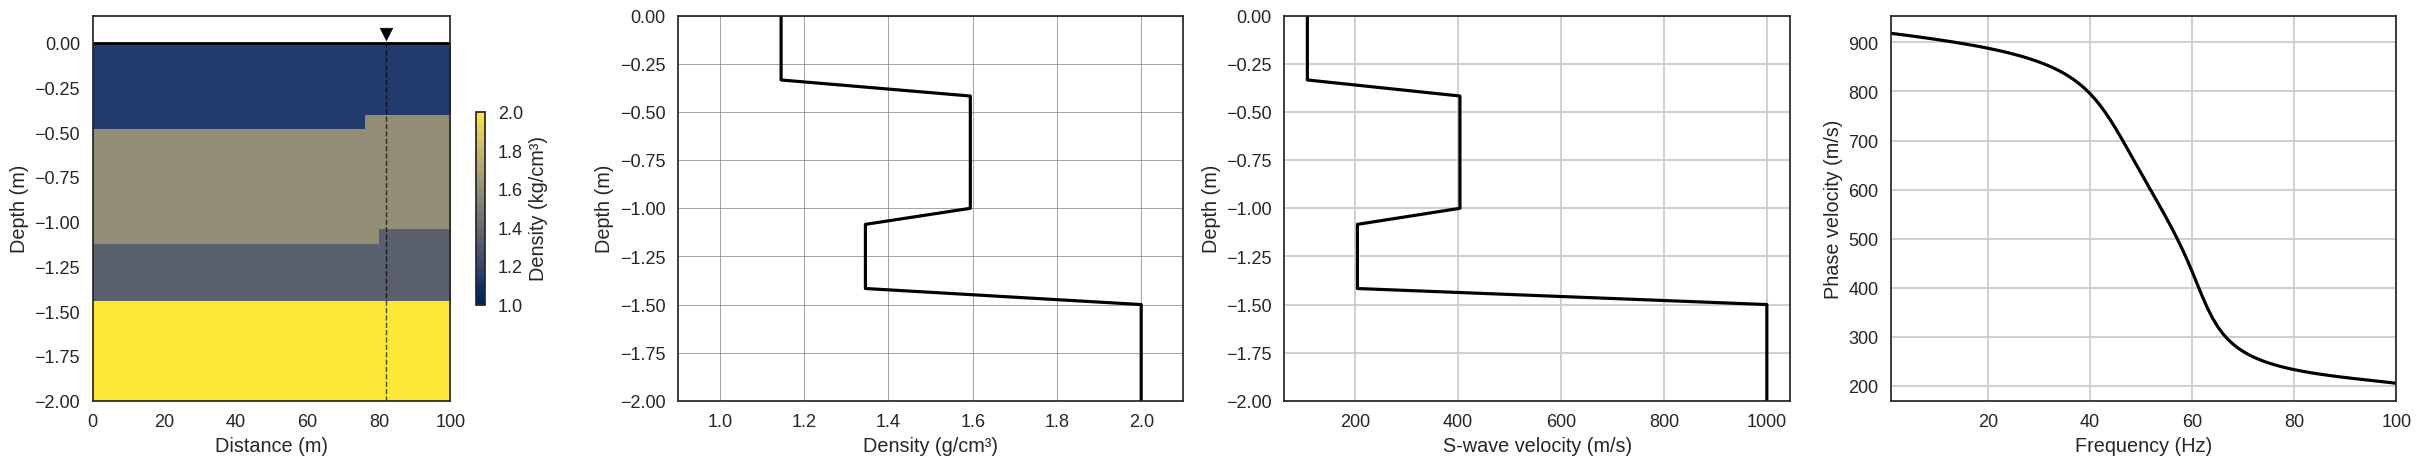

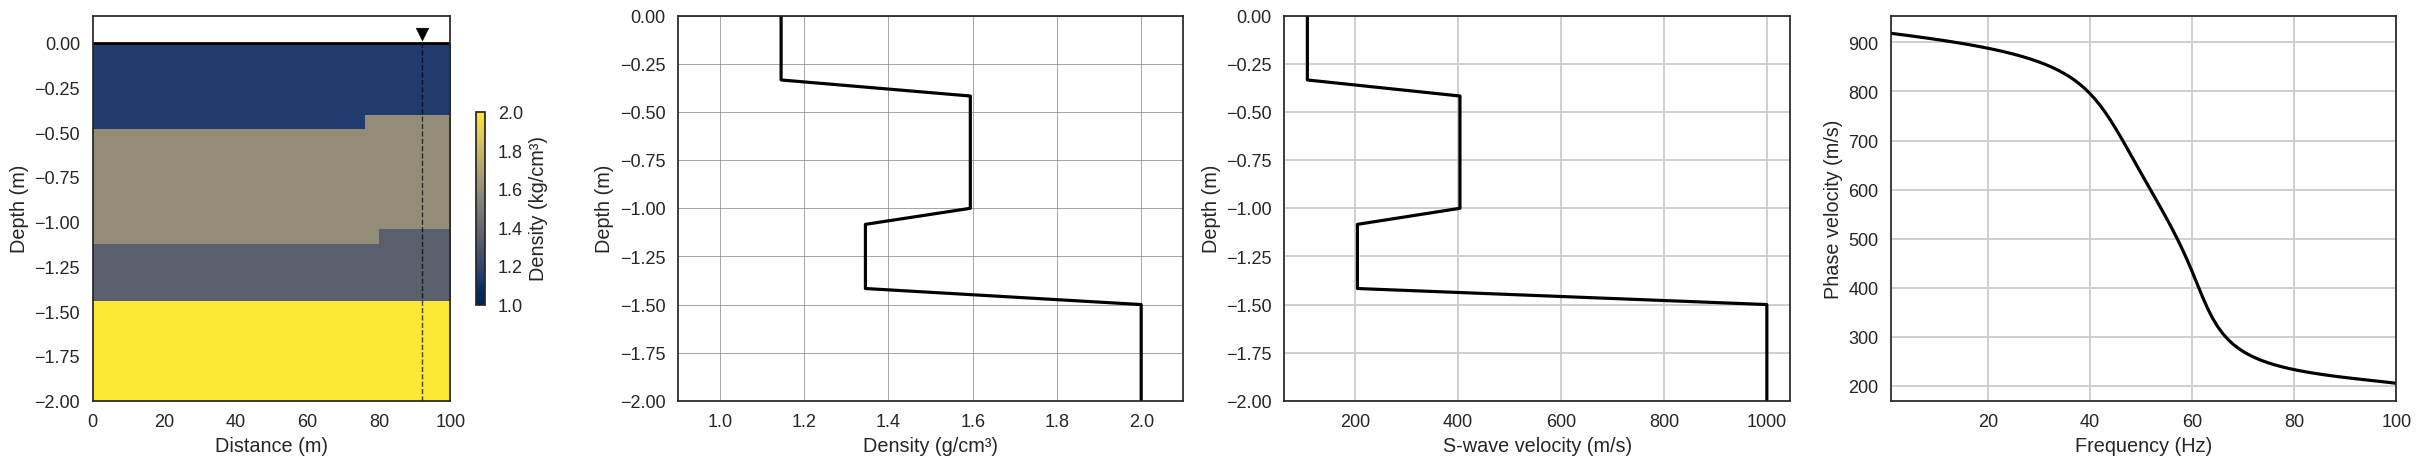

In [35]:
density_lst = []
vels_lst = []
depth_lst = []
dispersion_curve_lst = []
hz_lst = [] 

profile_number = np.random.random(size=1)

for ix in lst_receptor_index:
    fig, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(30, 5))
    
    # ----------
    # Slice plot
    
    im = ax.imshow(slice_block, cmap='cividis',extent=[0, 100, -2.0, 0],vmin=1.00,vmax=2.00,aspect=50,origin='lower')
    ax.vlines(x=ix*2,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix*2,y=0.05,color='k',marker='v')
    ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Depth (m)')
    plt.colorbar(im, ax=ax,fraction=0.2, shrink=0.5,label='Density (kg/cm³)')
    
    # --------------------
    # Density x Depth plot
    
    density_lst.append(slice_block[:,ix])  
    depth_lst.append(np.linspace(-2., 0,len(slice_block[:,ix])))  
    ax1.plot(slice_block[:,ix],np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax1.set_xlim(0.90,2.10)
    ax1.set_ylim(-2.0,0.0)
    ax1.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax1.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
    ax1.set_xlabel('Density (g/cm³)')
    ax1.set_ylabel('Depth (m)')
    
    # ------------------------------------------------------
    # Creating the velocity model in function of the density
    
    velocity_model = create_velocity_model_from_profile(model_profile=slice_block[:,ix][::-1])

    # -----------------------------------------------------------
    # Estimating P- and S-wave velocity in function of the density
    
    velocity_p,velocity_s = calculate_parameters(slice_block[:,ix])
    vels_lst.append(velocity_s)  

    # --------------------------------
    # Shear-wave velocity x Depth plot

    ax2.plot(velocity_s,np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax2.set_ylim(-2.0,0.0)
    ax2.grid('on')    
    ax2.set_xlabel('S-wave velocity (m/s)')
    ax2.set_ylabel('Depth (m)')

    # -----------------------------------------------------------
    # Compute the Rayleigh-wave fundamental mode dispersion curve
    
    cpr = estimate_disp_from_velocity_model(velocity_model)  

    dispersion_curve_lst.append(cpr.velocity*1000)
    hz_lst.append(1/cpr.period)
    
    # ---------------------
    # Dispersion curve plot
    
    ax3.plot(1/cpr.period,cpr.velocity*1000,'-k')
    ax3.grid('on')
    ax3.set_xlim(1,100)
    ax3.set_ylabel('Phase velocity (m/s)')
    ax3.set_xlabel('Frequency (Hz)')

    # ---------------------
    # Saving plot
    
    fig.savefig(figures_path+'slice_and_profiles_'+str(ix*2)+'.png')

## Create and save a dataframe with the observed data generated

In [36]:
dic_obs_data = {'receptor':lst_receptor_index,'station':station_lst,'density':density_lst,'velocity_s':vels_lst,'depth':depth_lst,'dispersion_curve':dispersion_curve_lst,'frequency':hz_lst}

In [37]:
obs_data = pd.DataFrame.from_dict(dic_obs_data)

In [38]:
obs_data.to_feather(data_path+'observed_data.feather')